<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: ???? </center></h4>
<h4><center> Filename: assignment_1_XX.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: Student Name, Student ID </center></h4>
<h4><center> Group Member 2: Student Name, Student ID </center></h4>
<h4><center> Group Member 3: Student Name, Student ID </center></h4>
<h4><center> Group Member 4: Student Name, Student ID </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



**To load data on Google Colab**:
1. Upload the data onto your Google Drive
2. Run the first cell to log in your Google account and mount on your Google Drive
3. Change *path_csv* and *path* accordingly

In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy
config.update("jax_platform_name", 'cpu') # use cpu if needed

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

import dlib
import cv2
import math

In [2]:
#load attributes csv file
path_csv  = "D:\\Academics\\DSA\\4212\\datasets" # Local Path (Change Here)
# path_csv  = '/content/gdrive/My Drive/DSA4212/datasets' # Google Drive
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))

In [3]:
#let us list all the files in the image directory
path = "D:\\Academics\\DSA\\4212\\datasets\\img_celeba_small" # Local Path (Change Here)
# path = "/content/img_celeba_small" # Google Drive
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


In [4]:
%%capture --no-display
url = "https://raw.githubusercontent.com/sightmachine/SimpleCV/master/SimpleCV/Features/HaarCascades/"
facial_parts = ['face', 'eye', 'mouth', 'nose']
for p in facial_parts:
    p_file = p + '.xml'
    p_url = url + p_file
    !wget {p_url}

## Common Utility Functions

In [4]:
def image_loader_fname(fnames, res, grey=False, crop = False):
    """
    Load Images by File Names

    args:
    fnames: file names of the image to be loaded (a list)
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    verbose: Print time elapsed for every 1000 loaded images if verbose == 1, default 0
    """
    start = time.time()
    if grey == True:
        img_array = onp.zeros((len(fnames), res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, res[0]*res[1])
    else:
        img_array = onp.zeros((len(fnames), res[0], res[1], 3))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, 3*res[0]*res[1])
            
    return img_array


In [6]:
# Feature extraction

def find_vertex(all_img):
    """
    find the average vertex of face, eyes, mouth and nose among all imgs

    args:
    fnames: file names of the image to be loaded (a list)
    
    output: A dictionary in the form of {face:(x,y,h,w); nose:(x,y,h,w); mouth:(x,y,h,w), eyes:(x,y,h,w) }
    """
    face_cascade = cv2.CascadeClassifier("face.xml")
    eye_cascade = cv2.CascadeClassifier("eye.xml")
    nose_cascade = cv2.CascadeClassifier("nose.xml")
    mouth_cascade = cv2.CascadeClassifier("mouth.xml")
    face_found = []
    eyes_found = []
    nose_found = []
    mouth_found = []
    
    start = time.time()
    for k in range(all_img.shape[0]):
        #load image
        img = cv2.imread(os.path.join(path, all_img[k]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(img)
        eyes = eye_cascade.detectMultiScale(img)
        nose = nose_cascade.detectMultiScale(img)
        mouth = mouth_cascade.detectMultiScale(img)

        not_found = np.array([[np.nan]])

        face_found.append(faces) if faces != () else face_found.append(not_found)
        eyes_found.append(eyes) if eyes != () else eyes_found.append(not_found)
        nose_found.append(nose) if nose != () else nose_found.append(not_found)
        mouth_found.append(mouth) if mouth != () else  mouth_found.append(not_found)
        
        if k % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images extracted: {i}, Time elapsed: {duration:.2f}")
    
    
    output = {}    

    temp = [x[0] for x in onp.squeeze(face_found)]
    face_vertex = pd.DataFrame(temp)
    [x,y,h,w] = face_vertex.dropna().mean()
    output["face"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(nose_found)]
    nose_vertex = pd.DataFrame(temp)
    [x,y,h,w] = nose_vertex.dropna().mean()
    output["nose"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(eyes_found)]
    eyes_vertex = pd.DataFrame(temp)
    [x,y,h,w] = eyes_vertex.dropna().mean()
    output["eyes"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(mouth_found)]
    mouth_vertex = pd.DataFrame(temp)
    [x,y,h,w] = mouth_vertex.dropna().mean()
    output["mouth"] = [x,y,h,w]
    
    return output


def image_area_loader(all_img,vertex,gray = False):
    """
    Load Images by area(face, mouth, nose, eyes)

    args:
    fnames: file names of the image to be loaded (a list)
    vertex: vertex (x,y,h,w) that the image to be loaded
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    """
    ceil = [math.ceil(v) for v in vertex ]
    [x,y,w,h] = ceil
    
    if gray == True:
        img_set= onp.zeros((size, h,w))

        for k in range(all_img.shape[0]):
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = im[y:y+h,x:x+w,:]
            im = onp.mean(im, axis=2)
            img_set[k,:,:] = im
            
            if k % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
    else:
        img_set= onp.zeros((size, h,w,3))

        for k in range(all_img.shape[0]):
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = im[y:y+h,x:x+w,:]
            img_set[k,:,:,:] = im
            
            if k % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
    
    return img_set

In [5]:
# Predict P(Y=1|X, Beta)
@jax.jit
def pred_proba(beta, x):
    """ predict the probability that label is +1 given x and beta """
    return 1. / (1. + jnp.exp(-jnp.dot(beta, x)))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [6]:
@jax.jit
def get_label(p, threshold=0.5):
    pred_bool = p > threshold
    pred_label = 2*pred_bool - 1
    return pred_label

def get_accuracy(p, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==get_label(p))

from sklearn.metrics import roc_auc_score

def get_auc(p, Y):
    return roc_auc_score(p, Y)

def test_acc(beta,Y_true, test_img_arr):
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    return test_acc

def test_auc(beta,Y_true, test_img_arr):
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_auc = get_auc(Y_true, test_pred)
    return test_auc

In [7]:
def test_acc_auc(beta, Y_true, test_img_arr):
    """
    Get the accuracy and AUC-ROC score for test data
     beta: Model Parameters
     Y_true: Ground truth labels
     test_img_arr: test images represented by an array
    """
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    test_auc = get_auc(Y_true, test_pred)
    
    print(f'Test Accuracy is {test_acc:.2f}')
    print(f'Test AUC is {test_auc:.2f}')
    
    return test_acc, test_auc

## Utility Functions for Basic Logistic Regression

In [8]:
@jax.jit
def loss_single(beta, x, y):
    """ logistic regression loss on a single image """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))
loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0)) # Vectorize Loss Function

In [9]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

## Utility Functions for Regularized Logistic Regression (Ridge, Lasso, ...)

In [10]:
### Ridge
@jax.jit
def loss_ridge(beta, X, Y, lambda_ridge=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_ridge: ridge parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = np.sum(loss_batch(beta, X, Y))
    loss_batch_ridge = loss_original + lambda_ridge*np.sum(beta**2)

    return loss_batch_ridge/len(Y)

# compute derivates
loss_ridge_grad = jax.jit(jax.grad(loss_ridge, argnums=0))
loss_ridge_values_and_grad = jax.jit(jax.value_and_grad(loss_ridge, argnums=0))

In [11]:
@jax.jit
def loss_lasso(beta, X, Y, lambda_lasso=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_lasso: lasso parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = np.sum(loss_batch(beta, X, Y))
    loss_batch_lasso = loss_original + lambda_lasso*np.sum(np.abs(beta))

    return loss_batch_lasso/len(Y)

# compute derivates
loss_lasso_grad = jax.jit(jax.grad(loss_lasso, argnums=0))
loss_lasso_values_and_grad = jax.jit(jax.value_and_grad(loss_lasso, argnums=0))

## Utility Functions for Training Model and Backcalling

In [12]:
def train_SGD(train_img, train_label, beta_init, lr, val_grad_fn, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "SGD",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [13]:
def train_SGD_step_decay(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with step decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        
        if (epoch + 1) % n_steps == 0:
            learning_rate = learning_rate * lr_decay
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Step Decay",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [14]:
def train_SGD_heuristic(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, valid_size=0.2, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with heuristic learning rate decay using SGD with heuristic learning rate decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     valid_size: Proportion of training images to be used as validation data
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    valid_acc_history = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr
    
    valid_img_arr = train_img[int(-valid_size*N):]
    valid_label = train_label[int(-valid_size*N):]

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        valid_acc_new = test_acc(beta, valid_label, valid_img_arr)
        valid_acc_history.append(valid_acc_new)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        
        if epoch == 0:
            valid_acc = valid_acc_new
        elif valid_acc_new < valid_acc:
            learning_rate = learning_rate * lr_decay
        valid_acc = valid_acc_new
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Heuristic",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'valid_acc_epoch': valid_acc_history,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [15]:
## with fixed decay_constant
def train_SGD_scheduled_decay(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, decay_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with scheduled decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     decay_constant: choise of decay_constant, defult 0.5
     
    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        
        learning_rate = learning_rate /(1 + decay_constant*epoch) # Schedule decay

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Scheduled Decay",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

In [16]:
## with fixed mom_constant
def train_SGD_mom(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, mom_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD plus momentum
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     mom_constant: choise of momentum constant, default 0.5

    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            mom = beta - beta_old
            beta_old = beta
            beta = beta - learning_rate*grad + mom_constant*mom


            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Momentum",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

## Utility Functions for Plotting Graph

In [17]:
def plot_loss(loss_history):
    plt.plot(loss_history, "-^")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.grid(True)

In [18]:
def record_graph(record_list, key='test_acc_epoch', n = None):
    """
    Plot graph of records in the list
    
    Args:
     record_list: List of record (dictionary) as returned by model training functions
     key: Performance metric to be plotted
     n: Number of results to be plotted, full results will be plotted if None
     
    Output:
     Multiple lines of the record on the same graph
    """
    keys = record_list[0].keys()
    if key not in keys:
        print(f'{key} is an invalid key!')
        print(f'Please enter one of the following: {keys}')
        
    plt.figure(figsize=(16,10))
        
    for record in record_list:
        if n == None:
            n = len(record.get(key))
        y = record.get(key)[:n]
        x = np.arange(n)
        plt.xticks(x)
        plt.plot(x,
                 y, 
                 "-.",
                 alpha=0.6,
                 label=record.get('name'))
    
    plt.legend()
    plt.xlabel(f'{key}'.split('_')[-1])
    plt.ylabel(' '.join(f'{key}'.split('_')[:-1]))
    plt.grid(True)
    plt.title("Summary of Results");

## Import Data
### Notice: Images are only loaded as file names at this stage, to read as numerical arrays, use image_loader/image_loader_fname

In [19]:
# Proportion of Males in first 15000? first 200?
train_img = all_img[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1)

test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)

train_small_img = all_img[:200]
train_small_label = attribute['Male'][:200]
train_small_label = np.array(train_small_label).reshape(-1)

### Delete the arrays to clear up memeory and prevent RAM OOM

In [20]:
import gc
def clear_image_cache(var_list):
    for var in var_list:
        if var in globals().keys():
            del globals()[var]
    gc.collect()
    time.sleep(1)
# del test_img_arr
# del train_img_arr

### Convert images into numerical arrays

In [21]:
img_list = ['test_img_arr', 'train_img_arr']
clear_image_cache(img_list)

pixels = 100
res = [pixels, pixels]
grey = False

train_img_arr = image_loader_fname(train_img[:200], res, grey)
test_img_arr = image_loader_fname(test_img, res, grey)

NameError: name 'image_loader_fname' is not defined

In [65]:
len(train_img)

15000

In [66]:
train_img_arr.shape

(15000, 30000)

In [67]:
test_img_arr.shape

(5000, 30000)

## Basic SGD

In [129]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / pixels
beta_init = np.random.normal(0,beta_standard_dev,3*pixels*pixels)

In [131]:
beta_SGD, record_SGD = train_SGD(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, mb_size = 100, verbose = 1)

Epoch 0: 13.25 seconds, Loss: 15.45, Test Accuracy: 0.564
Epoch 1: 12.85 seconds, Loss: 12.70, Test Accuracy: 0.593
Epoch 2: 13.26 seconds, Loss: 11.46, Test Accuracy: 0.607
Epoch 3: 12.98 seconds, Loss: 10.58, Test Accuracy: 0.622
Epoch 4: 13.76 seconds, Loss: 9.88, Test Accuracy: 0.636
Epoch 5: 13.23 seconds, Loss: 9.33, Test Accuracy: 0.648
Epoch 6: 12.49 seconds, Loss: 8.84, Test Accuracy: 0.657
Epoch 7: 12.30 seconds, Loss: 8.39, Test Accuracy: 0.666
Epoch 8: 12.34 seconds, Loss: 8.07, Test Accuracy: 0.673
Epoch 9: 12.44 seconds, Loss: 7.74, Test Accuracy: 0.681


In [86]:
acc_test, auc_test = test_acc_auc(beta_SGD, test_label, test_img_arr)

Test Accuracy is 0.69
Test AUC is 0.72


## Annealing

### Step Decay

In [132]:
beta_step, record_step = train_SGD_step_decay(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, mb_size=100, verbose = 1)

Epoch 0: 12.45 seconds, Loss: 15.44, Test Accuracy: 0.564
Epoch 1: 12.74 seconds, Loss: 12.74, Test Accuracy: 0.593
Epoch 2: 12.93 seconds, Loss: 11.46, Test Accuracy: 0.607
Epoch 3: 14.52 seconds, Loss: 10.59, Test Accuracy: 0.622
Epoch 4: 12.87 seconds, Loss: 9.88, Test Accuracy: 0.636
Epoch 5: 12.68 seconds, Loss: 9.44, Test Accuracy: 0.645
Epoch 6: 12.62 seconds, Loss: 9.14, Test Accuracy: 0.651
Epoch 7: 12.49 seconds, Loss: 8.92, Test Accuracy: 0.656
Epoch 8: 14.10 seconds, Loss: 8.70, Test Accuracy: 0.660
Epoch 9: 13.47 seconds, Loss: 8.50, Test Accuracy: 0.664


In [30]:
acc_test, auc_test = test_acc_auc(beta_step, test_label, test_img_arr)

Test Accuracy is 0.77
Test AUC is 0.83


### Heuristic

In [133]:
beta_heuristic, record_heuristic = train_SGD_heuristic(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, verbose = 1)

Epoch 0: 13.12 seconds, Loss: 15.44, Test Accuracy: 0.565
Epoch 1: 12.99 seconds, Loss: 12.71, Test Accuracy: 0.593
Epoch 2: 12.84 seconds, Loss: 11.49, Test Accuracy: 0.608
Epoch 3: 12.98 seconds, Loss: 10.60, Test Accuracy: 0.621
Epoch 4: 14.36 seconds, Loss: 9.92, Test Accuracy: 0.636
Epoch 5: 12.66 seconds, Loss: 9.34, Test Accuracy: 0.647
Epoch 6: 15.08 seconds, Loss: 8.86, Test Accuracy: 0.658
Epoch 7: 18.81 seconds, Loss: 8.42, Test Accuracy: 0.665
Epoch 8: 18.64 seconds, Loss: 8.06, Test Accuracy: 0.673
Epoch 9: 18.76 seconds, Loss: 7.74, Test Accuracy: 0.680


In [33]:
acc_test, auc_test = test_acc_auc(beta_heuristic, test_label, test_img_arr)

Test Accuracy is 0.79
Test AUC is 0.85


### 1/t decay

In [138]:
beta_schedule, record_schedule = train_SGD_scheduled_decay(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, mb_size = 100, verbose = 1)

Epoch 0: 17.98 seconds, Loss: 15.42, Test Accuracy: 0.564
Epoch 1: 15.11 seconds, Loss: 12.75, Test Accuracy: 0.593
Epoch 2: 17.46 seconds, Loss: 11.58, Test Accuracy: 0.605
Epoch 3: 18.27 seconds, Loss: 11.09, Test Accuracy: 0.610
Epoch 4: 30.47 seconds, Loss: 10.89, Test Accuracy: 0.614
Epoch 5: 36.80 seconds, Loss: 10.78, Test Accuracy: 0.615
Epoch 6: 35.73 seconds, Loss: 10.75, Test Accuracy: 0.615
Epoch 7: 34.14 seconds, Loss: 10.75, Test Accuracy: 0.615
Epoch 8: 34.02 seconds, Loss: 10.74, Test Accuracy: 0.615
Epoch 9: 33.35 seconds, Loss: 10.75, Test Accuracy: 0.615


In [39]:
acc_test, auc_test = test_acc_auc(beta_schedule, test_label, test_img_arr)

Test Accuracy is 0.71
Test AUC is 0.76


## Momentum a.k.a Heavy Ball Method

In [139]:
beta_mom, record_mom = train_SGD_mom(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, mb_size = 100, verbose = 1)

Epoch 0: 29.20 seconds, Loss: 14.17, Test Accuracy: 0.578
Epoch 1: 34.49 seconds, Loss: 11.09, Test Accuracy: 0.615
Epoch 2: 46.76 seconds, Loss: 9.70, Test Accuracy: 0.640
Epoch 3: 54.15 seconds, Loss: 8.71, Test Accuracy: 0.662
Epoch 4: 35.91 seconds, Loss: 7.99, Test Accuracy: 0.676
Epoch 5: 41.82 seconds, Loss: 7.37, Test Accuracy: 0.689
Epoch 6: 36.39 seconds, Loss: 6.93, Test Accuracy: 0.701
Epoch 7: 36.45 seconds, Loss: 6.53, Test Accuracy: 0.708
Epoch 8: 35.60 seconds, Loss: 6.24, Test Accuracy: 0.717
Epoch 9: 35.06 seconds, Loss: 5.91, Test Accuracy: 0.723


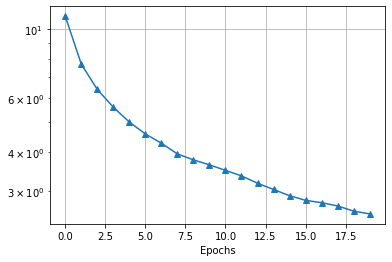

In [41]:
plot_loss(loss_epoch_mom)

In [42]:
acc_test, auc_test = test_acc_auc(beta_mom, test_label, test_img_arr)

Test Accuracy is 0.84
Test AUC is 0.91


## Example on Plotting Results

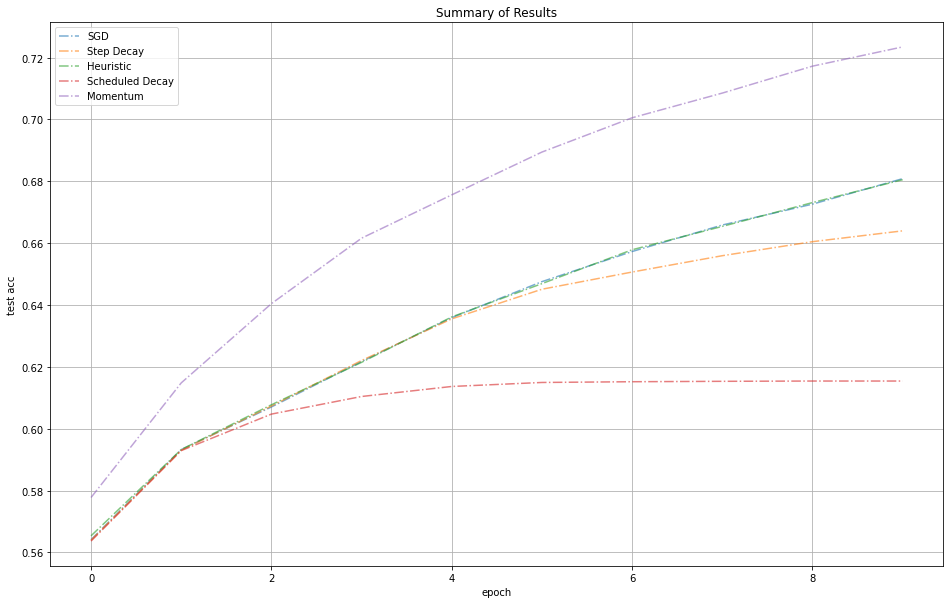

In [154]:
record_list = [record_SGD, record_step, record_heuristic, record_schedule, record_mom]

record_graph(record_list, 'test_acc_epoch')

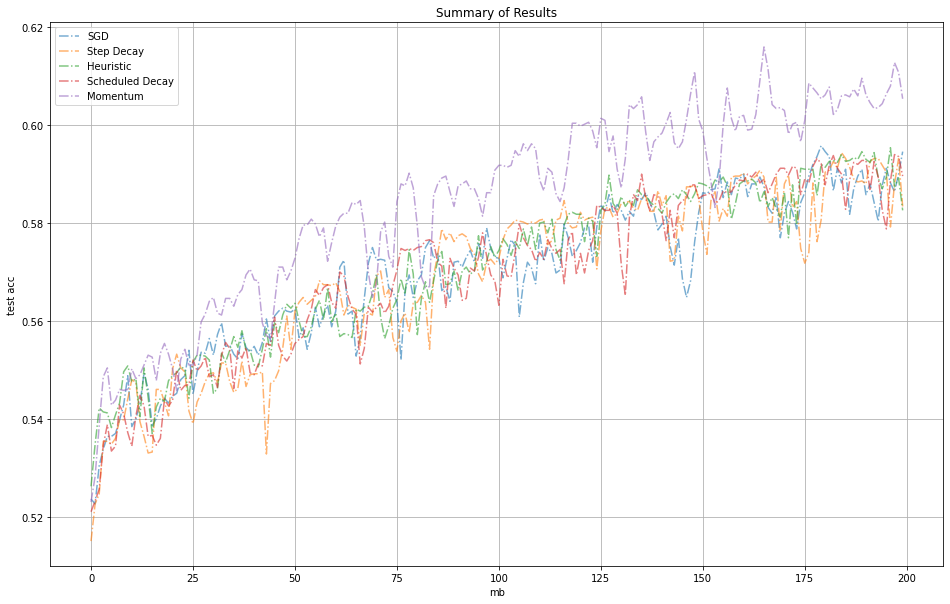

In [155]:
record_graph(record_list, 'test_acc_mb', 200)

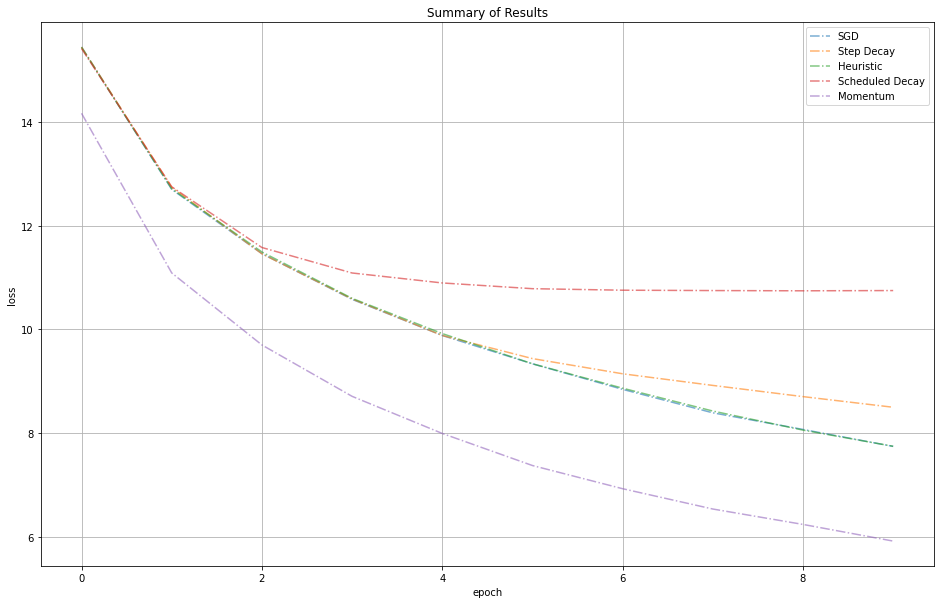

In [156]:
record_graph(record_list, 'loss_epoch')

# Extract Feature

In [23]:
vertex = find_vertex(all_img)

AttributeError: 'list' object has no attribute 'shape'

## Train extracted face with SGD

In [ ]:
face_train = image_area_loader(train_img, vertex['face']).reshape(-1, 3 * 104 * 104)
face_test =  image_area_loader(test_img, vertex['face']).reshape(-1, 3 * 104 * 104)

In [ ]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / 104
face_beta_init = np.random.normal(0,beta_standard_dev,3*104*104)

In [ ]:
test_img_arr = face_test

beta_face, record_face = train_SGD(
    face_train, train_label, face_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 50, mb_size = 100, verbose = 1)

## Train extracted nose with standard SGD

In [ ]:
nose_train = image_area_loader(train_img, vertex['nose']).reshape(-1, 3 * 30 * 25)
nose_test =  image_area_loader(test_img, vertex['nose']).reshape(-1, 3 * 30 * 25)

In [ ]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / np.sqrt(30*25)
nose_beta_init = np.random.normal(0,beta_standard_dev,3*30*25)

In [ ]:
test_img_arr = nose_test

beta_nose, record_nose = train_SGD(
    nose_train, train_label, nose_beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 50, mb_size = 100, verbose = 1)

## Train extracted eyes with stardard SGD

In [ ]:
eyes_train = image_area_loader(train_img, vertex['eyes']).reshape(-1, 3 * 27 * 27)
eyes_test =  image_area_loader(test_img, vertex['eyes']).reshape(-1, 3 * 27 * 27)

In [ ]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / np.sqrt(27*27)
eyes_beta_init = np.random.normal(0,beta_standard_dev,3*27*27)

In [ ]:
test_img_arr = eyes_test

beta_eyes, record_eyes = train_SGD(
    eyes_train, train_label, eyes_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 50, mb_size = 100, verbose = 1)

## Train extracted mouth with stardard SGD

In [1]:
mouth_train = image_area_loader(train_img, vertex['mouth']).reshape(-1, 3 * 40 * 24)
mouth_test =  image_area_loader(test_img, vertex['mouth']).reshape(-1, 3 * 40 * 24)

NameError: name 'image_area_loader' is not defined

In [ ]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / np.sqrt(40*24)
mouth_beta_init = np.random.normal(0,beta_standard_dev,3*40*24)

In [ ]:
test_img_arr = mouth_test

beta_mouth, record_mouth = train_SGD(
    mouth_train, train_label, mouth_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 50, mb_size = 100, verbose = 1)

## Ensemble model

In [ ]:
nose_prob_train = pred_proba_batch(beta_nose, nose_train)
eyes_prob_train = pred_proba_batch(beta_eyes, eyes_train)
mouth_prob_train = pred_proba_batch(beta_mouth, mouth_train)

nose_prob_test = pred_proba_batch(beta_nose, nose_test)
eyes_prob_test = pred_proba_batch(beta_eyes, eyes_test)
mouth_prob_test = pred_proba_batch(beta_mouth, mouth_test)

In [ ]:
ensemble_train = np.column_stack((nose_prob_train,  eyes_prob_train, mouth_prob_train))
ensemble_test = np.column_stack((nose_prob_test,  eyes_prob_test, mouth_prob_test))
print(ensemble_train.shape)
print(ensemble_test.shape)

In [ ]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) 
ensemble_beta_init = np.random.normal(0,beta_standard_dev,3)

In [ ]:
test_img_arr = ensemble_test

beta_ensemble, record_ensemble = train_SGD(
    ensemble_train, train_label, ensemble_beta_init, 1, loss_LR_values_and_grad, n_epoch = 20, mb_size = 15000, verbose = 1)

In [ ]:
beta_ensemble

## Ensemble By Majority Voting

In [ ]:
# Give the prediction by majority voting
def ensemble_voting(ensemble):
    voting = np.mean(ensemble_train > 0.5 , axis = 1)
    pred = np.array([1 if v > 0.5 else 0 for v in voting])
    return pred

In [ ]:
get_accuracy(ensemble_voting(ensemble_train), train_label)